In [139]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from numpy_ext import rolling_apply

In [138]:
!pip install numpy_ext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.1/303.1 KB 5.0 MB/s eta 0:00:000:00:01
You should consider upgrading via the '/Users/monikawysoczanska/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib notebook

Get the data from IBL format

In [7]:
# !pip install --quiet nma-ibl

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ray 1.7.0 requires msgpack<2.0.0,>=1.0.0, which is not installed.
You should consider upgrading via the '/Users/monikawysoczanska/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [9]:
# import datajoint as dj
# dj.config['database.host'] = 'datajoint-public.internationalbrainlab.org'
# dj.config['database.user'] = 'ibl-public'
# dj.config['database.password'] = 'ibl-public'
# from nma_ibl import reference, subject, action, acquisition, data, behavior, behavior_analyses

[2023-07-18 09:46:15,130][INFO]: Connecting ibl-public@datajoint-public.internationalbrainlab.org:3306
[2023-07-18 09:46:16,500][INFO]: Connected ibl-public@datajoint-public.internationalbrainlab.org:3306


In [15]:
# data = ((behavior.TrialSet.Trial & 'trial_response_choice !="No Go"') * (subject.Subject & 'subject_birth_date > "2019-08-01"') * acquisition.Session * behavior_analyses.PsychResultsBlock).fetch(format='frame')


In [21]:
# pickle.dump(data, open('data.p', 'wb'))

## Data reading

In [2]:
with open('data.p', 'rb') as f:
    data = pickle.load(f)

The columns that we have

In [3]:
pd.DataFrame(data.columns)

,0
0,trial_start_time
1,trial_end_time
2,trial_response_time
3,trial_response_choice
4,trial_stim_on_time
5,trial_stim_contrast_left
6,trial_stim_contrast_right
7,trial_feedback_time
8,trial_feedback_type
9,trial_rep_num


## Preprocessing 

In [4]:
data = data.reset_index()
data['subject_uuid'] = data['subject_uuid'].astype('string')
data['session_uuid'] = data['session_uuid'].astype('string')

In [45]:
data['signed_contrast'] = data['trial_stim_contrast_right'] - data['trial_stim_contrast_left']
data['report_right'] = data['trial_response_choice'] == "CCW"

columns we actually need for the modelling

In [52]:
COLS = ['subject_uuid', 'session_start_time', 'trial_id', 'prob_left', 'trial_response_choice', 'trial_stim_contrast_right', 'trial_stim_contrast_left', 'signed_contrast']

In [318]:
data_df = data[COLS]

data_df.to_csv('ibl_dataframe.csv')
data_df

,subject_uuid,session_start_time,trial_id,prob_left,trial_response_choice,trial_stim_contrast_right,trial_stim_contrast_left,signed_contrast
0,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-20 13:07:43,1,0.5,CCW,0.0,1.0000,-1.0000
1,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-20 13:07:43,2,0.5,CCW,0.0,1.0000,-1.0000
2,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-20 13:07:43,3,0.5,CW,0.0,1.0000,-1.0000
3,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-20 13:07:43,4,0.5,CCW,0.0,1.0000,-1.0000
4,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-20 13:07:43,5,0.5,CW,0.0,1.0000,-1.0000
...,...,...,...,...,...,...,...,...
2851489,ffcd8c5e-fe0c-4d6d-8418-d9152f1746f1,2020-01-24 09:57:45,628,0.5,CW,0.0,0.0625,-0.0625
2851490,ffcd8c5e-fe0c-4d6d-8418-d9152f1746f1,2020-01-24 09:57:45,628,0.8,CW,0.0,0.0625,-0.0625
2851491,ffcd8c5e-fe0c-4d6d-8418-d9152f1746f1,2020-01-24 09:57:45,629,0.2,CCW,0.0,0.0625,-0.0625
2851492,ffcd8c5e-fe0c-4d6d-8418-d9152f1746f1,2020-01-24 09:57:45,629,0.5,CCW,0.0,0.0625,-0.0625


In [315]:
def history_presentation(sides, outputs):

  # sides : np.array of the sides where the stimulus was presented (-1: Left, 1: right)
  # outputs : np.array of the outputs (0: incorrect, 1: correct)

  reinforced = sides * outputs
  punished = sides * (1 - outputs)
  
  return(np.sum(reinforced - punished))


def history_decision(decisions, outputs):

  # decisions : np.array of the decisions where the stimulus was presented (-1: Left, 1: right)
  # outputs : np.array of the outputs (0: incorrect, 1: correct)

  reinforced = decisions * outputs
  punished = decisions * (1 - outputs)
  
  return(np.sum(reinforced - punished))


# def stimulus(sides):

#   # sides : np.array of the sides where the stimulus was presented (-1: Left, 1: right)
  
#   return(sides)


# def bias(sides):

#   # sides : np.array of the sides where the stimulus was presented (-1: Left, 1: right)

#   return(np.mean(sides))

In [312]:
def apply_hist_per_subject(x, window_size, func):
    
    x = x.values
    result = np.zeros(x.shape[0])
    padded = np.vstack([np.zeros((window_size, x.shape[1])), x])  
    for i in range(window_size, padded.shape[0]):
        x1, x2 = padded[i-window_size: i, 0], padded[i-window_size: i, 1]
        result[i-window_size] = func(x1, x2)
        
    return pd.DataFrame(result, columns=[str(func)])

In [316]:
def create_dataset(df, window_size):
    # input df, 
    
    # output 
    # X: np.array(N, n_features)
    # y: np.array(N,)
    
#     1. history_presentation
#     2. history_decision
#     3. stimulus
#     4. bias

    df.sort_values(by=['session_start_time', 'trial_id'], inplace=True)
    df['sides'] = df['signed_contrast']
    df.loc[df.sides > 0, "sides"] = 1
    df.loc[df.sides < 0, "sides"] = -1
    
    # to double check
    df.loc[df.trial_response_choice == "CCW", "trial_response_choice"] = 1
    df.loc[df.trial_response_choice == "CW", "trial_response_choice"] = -1
    
    df['correct'] = df.trial_response_choice == df.sides
    
    df['history_presentation'] = (df.groupby("subject_uuid")['sides', 'correct'].apply(lambda x: apply_per_subject(x, window_size, history_presentation)).reset_index()).iloc[:, -1]
    df['history_decision'] = (df.groupby("subject_uuid")['trial_response_choice', 'correct'].apply(lambda x: apply_per_subject(x, window_size, history_decision)).reset_index()).iloc[:, -1]

    return df.values
    

In [317]:
create_dataset(data_df, 10)

/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_51927/4006857817.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['session_start_time', 'trial_id'], inplace=True)
/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_51927/4006857817.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sides'] = df['signed_contrast']
/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_51927/4006857817.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

array([['b4cb0a93-4975-4a2d-aa12-94461d457594',
        Timestamp('2019-10-30 10:33:13'), 1, ..., True, 0.0, 0.0],
       ['b4cb0a93-4975-4a2d-aa12-94461d457594',
        Timestamp('2019-10-30 10:33:13'), 2, ..., True, -1.0, -1.0],
       ['b4cb0a93-4975-4a2d-aa12-94461d457594',
        Timestamp('2019-10-30 10:33:13'), 3, ..., False, 0.0, 0.0],
       ...,
       ['5f17f30c-e525-4931-b8e4-6054cf277987',
        Timestamp('2022-02-02 17:13:17'), 580, ..., True, -2.0, 4.0],
       ['5f17f30c-e525-4931-b8e4-6054cf277987',
        Timestamp('2022-02-02 17:13:17'), 580, ..., True, -2.0, 4.0],
       ['5f17f30c-e525-4931-b8e4-6054cf277987',
        Timestamp('2022-02-02 17:13:17'), 580, ..., True, -2.0, 4.0]],
      dtype=object)

Getting the dataframe for one subject

In [38]:
s_uuid = 'ed8918e4-6a37-4b3d-9b4d-daa14eca0c70'

/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_51927/3676233848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_per_sub['index'] = data_per_sub.index


KeyboardInterrupt: 

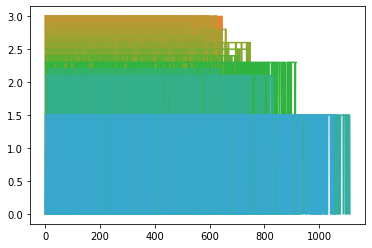

In [41]:
fig, ax = plt.subplots()
data_per_sub = data[data['subject_uuid'] == s_uuid]
data_per_sub['index'] = data_per_sub.index
sns.lineplot(data = data_per_sub, x ='trial_id', y = 'trial_reward_volume', hue = 'session_uuid', legend=False)


In [40]:
data_per_sub['prob_left'].unique()

array([0.5, 0.2, 0.8])

Info about sessions per subject 
- every 2 days (sometimes 4 days - weekend?)


Potential Q: Is there a drop in performance after longer break?

## Getting stimulus contrast data

In [11]:
data_per_sub[['trial_stim_contrast_left', 'trial_stim_contrast_right']]

,trial_stim_contrast_left,trial_stim_contrast_right
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
4928,0.0,0.5
4929,0.0,1.0
4930,1.0,0.0
4931,0.0,0.5


Reproducing data preparation from the paper

<AxesSubplot:>

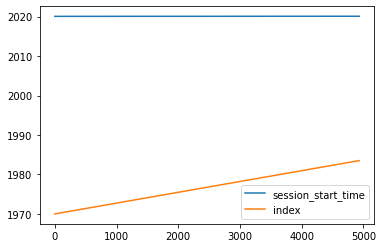

In [16]:
data_per_sub = data_per_sub.sort_values('session_start_time')
data_per_sub[['session_start_time', 'index']].plot()

<AxesSubplot:xlabel='index', ylabel='prob_left_block'>

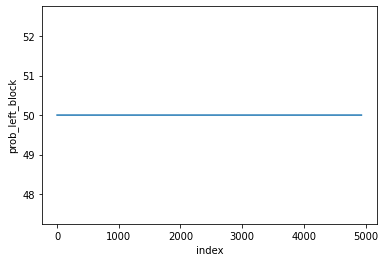

In [29]:
fig, ax = plt.subplots()
sns.lineplot(data=data_per_sub, x = 'index', y='prob_left_block')
# FOLLOW UP: see differences between mice

In [20]:
data_per_sub

,subject_uuid,session_start_time,trial_id,prob_left_block,trial_start_time,trial_end_time,trial_response_time,trial_response_choice,trial_stim_on_time,trial_stim_contrast_left,...,n_trials_stim,n_trials_stim_right,prob_choose_right,threshold,bias,lapse_low,lapse_high,signed_contrast,report_right,index
0,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-20 13:07:43,1,50,0.0000,10.273903,7.7019,CCW,NaN,1.0,...,"[56, 66, 45, 33]","[34, 44, 25, 20]","[0.6071428571428571, 0.6666666666666666, 0.555...",8.92982,-2.32644,0.639344,0.423077,-1.0,True,0
127,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-20 13:07:43,128,50,1401.6754,1411.450603,1408.8793,CW,1404.0122,0.0,...,"[56, 66, 45, 33]","[34, 44, 25, 20]","[0.6071428571428571, 0.6666666666666666, 0.555...",8.92982,-2.32644,0.639344,0.423077,0.5,False,127
128,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-20 13:07:43,129,50,1411.9136,1435.561502,1433.9981,CW,1425.5117,0.5,...,"[56, 66, 45, 33]","[34, 44, 25, 20]","[0.6071428571428571, 0.6666666666666666, 0.555...",8.92982,-2.32644,0.639344,0.423077,-0.5,False,128
129,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-20 13:07:43,130,50,1436.4417,1446.550002,1443.9829,CW,1437.1835,0.0,...,"[56, 66, 45, 33]","[34, 44, 25, 20]","[0.6071428571428571, 0.6666666666666666, 0.555...",8.92982,-2.32644,0.639344,0.423077,1.0,False,129
130,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-20 13:07:43,131,50,1447.0173,1469.077203,1466.5145,CW,1465.6609,0.0,...,"[56, 66, 45, 33]","[34, 44, 25, 20]","[0.6071428571428571, 0.6666666666666666, 0.555...",8.92982,-2.32644,0.639344,0.423077,1.0,False,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-30 10:09:53,223,50,1209.2681,1213.205502,1210.6418,CW,1209.9332,0.0,...,"[122, 143, 203, 196]","[6, 13, 89, 76]","[0.04918032786885246, 0.09090909090909091, 0.4...",15.90750,-36.47070,0.049180,0.586466,1.0,False,4491
4492,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-30 10:09:53,224,50,1213.6820,1216.683102,1215.1331,CCW,1214.2831,0.0,...,"[122, 143, 203, 196]","[6, 13, 89, 76]","[0.04918032786885246, 0.09090909090909091, 0.4...",15.90750,-36.47070,0.049180,0.586466,1.0,True,4492
4493,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-30 10:09:53,225,50,1217.1587,1222.849503,1220.2984,CW,1220.0219,0.0,...,"[122, 143, 203, 196]","[6, 13, 89, 76]","[0.04918032786885246, 0.09090909090909091, 0.4...",15.90750,-36.47070,0.049180,0.586466,0.5,False,4493
4495,01be78e7-8741-4b40-bd64-79ed745431b5,2020-01-30 10:09:53,227,50,1226.3201,1231.366102,1228.8158,CW,1226.9553,0.0,...,"[122, 143, 203, 196]","[6, 13, 89, 76]","[0.04918032786885246, 0.09090909090909091, 0.4...",15.90750,-36.47070,0.049180,0.586466,1.0,False,4495


<IPython.core.display.Javascript object>


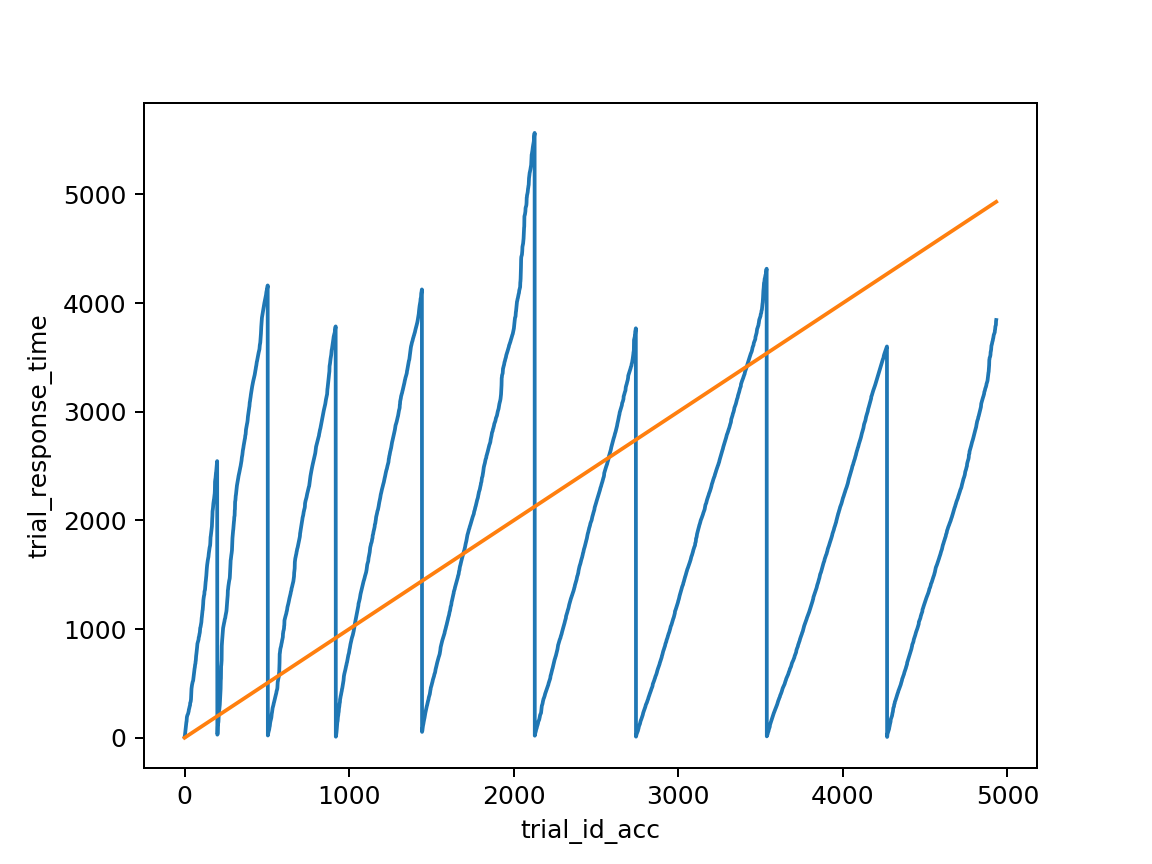

<AxesSubplot:xlabel='trial_id_acc', ylabel='trial_response_time'>

In [75]:
fig, ax = plt.subplots()
sns.lineplot(data=data_per_sub, x = 'trial_id_acc', y='trial_response_time')

We see that for each trial we need to subtract start time in order to get absolute times

In [84]:
data_per_sub['trial_response_time'] - data_per_sub['trial_start_time']


0        7.7019
127      7.2039
128     22.0845
129      7.5412
130     19.4972
         ...   
4491     1.3737
4492     1.4511
4493     3.1397
4495     2.4957
4932     6.0712
Length: 4933, dtype: float64

trial start time -> trial stim on time -> go cue time -> response time

Looking at 

In [239]:
ss_uuid = '1dbfd8ae-93ff-44d9-9fd8-14ac6e4575ab'
trial_id = 10
st_df = data_per_sub[data_per_sub['session_uuid'] == ss_uuid]
t_df = st_df[st_df['trial_id'] == trial_id]

finding the time columns

In [242]:
cols =[c for c in t_df.columns if 'time' in c ]
pd.DataFrame(cols)


,0
0,session_start_time
1,trial_start_time
2,trial_end_time
3,trial_response_time
4,trial_stim_on_time
5,trial_feedback_time
6,trial_go_cue_time
7,trial_go_cue_trigger_time
8,session_end_time


In [243]:
t_df_t = t_df[cols].T
t_df_t.columns = ['time']
t_df_t[~t_df_t.index.isin(['session_start_time', 'session_end_time'])].sort_values(by='time')

,time
trial_start_time,114.0396
trial_stim_on_time,114.6276
trial_go_cue_trigger_time,114.628
trial_go_cue_time,114.659
trial_response_time,132.0122
trial_feedback_time,132.0123
trial_end_time,133.571403


to get absolute times we need to subtruct the start time 
- 'decision time' = trial_response_time - trial_go_cue_time (trial_stim_on_time) 

# getting the wrong/right decision

In [119]:
data_per_sub['trial_response_choice'], data_per_sub['report_right']

(0       CCW
 1       CCW
 2        CW
 3       CCW
 4        CW
        ... 
 4928    CCW
 4929     CW
 4930     CW
 4931     CW
 4932     CW
 Name: trial_response_choice, Length: 4933, dtype: object,
 0        True
 1        True
 2       False
 3        True
 4       False
         ...  
 4928     True
 4929    False
 4930    False
 4931    False
 4932    False
 Name: report_right, Length: 4933, dtype: bool)

Deriving a correct answer

In [125]:
data_per_sub['GT_right'] = data_per_sub['signed_contrast'] > 0
data_per_sub['correct'] = data_per_sub['GT_right'] == data_per_sub['report_right']

/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_42096/3125341685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_per_sub['GT_right'] = data_per_sub['signed_contrast'] > 0


In [204]:
mat = data_per_sub[['correct','session_start_time', 'trial_id']]
mat['correct'] = mat['correct'].astype('int')
mat['session_start_time'] = mat['session_start_time'].dt.strftime("%m/%d")
mat = mat.pivot(columns=['session_start_time'], values='correct', index='trial_id').T

/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_42096/3519265263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat['correct'] = mat['correct'].astype('int')
/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_42096/3519265263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat['session_start_time'] = mat['session_start_time'].dt.strftime("%m/%d")


# Plot of correct answers for one subject in each trial

<IPython.core.display.Javascript object>


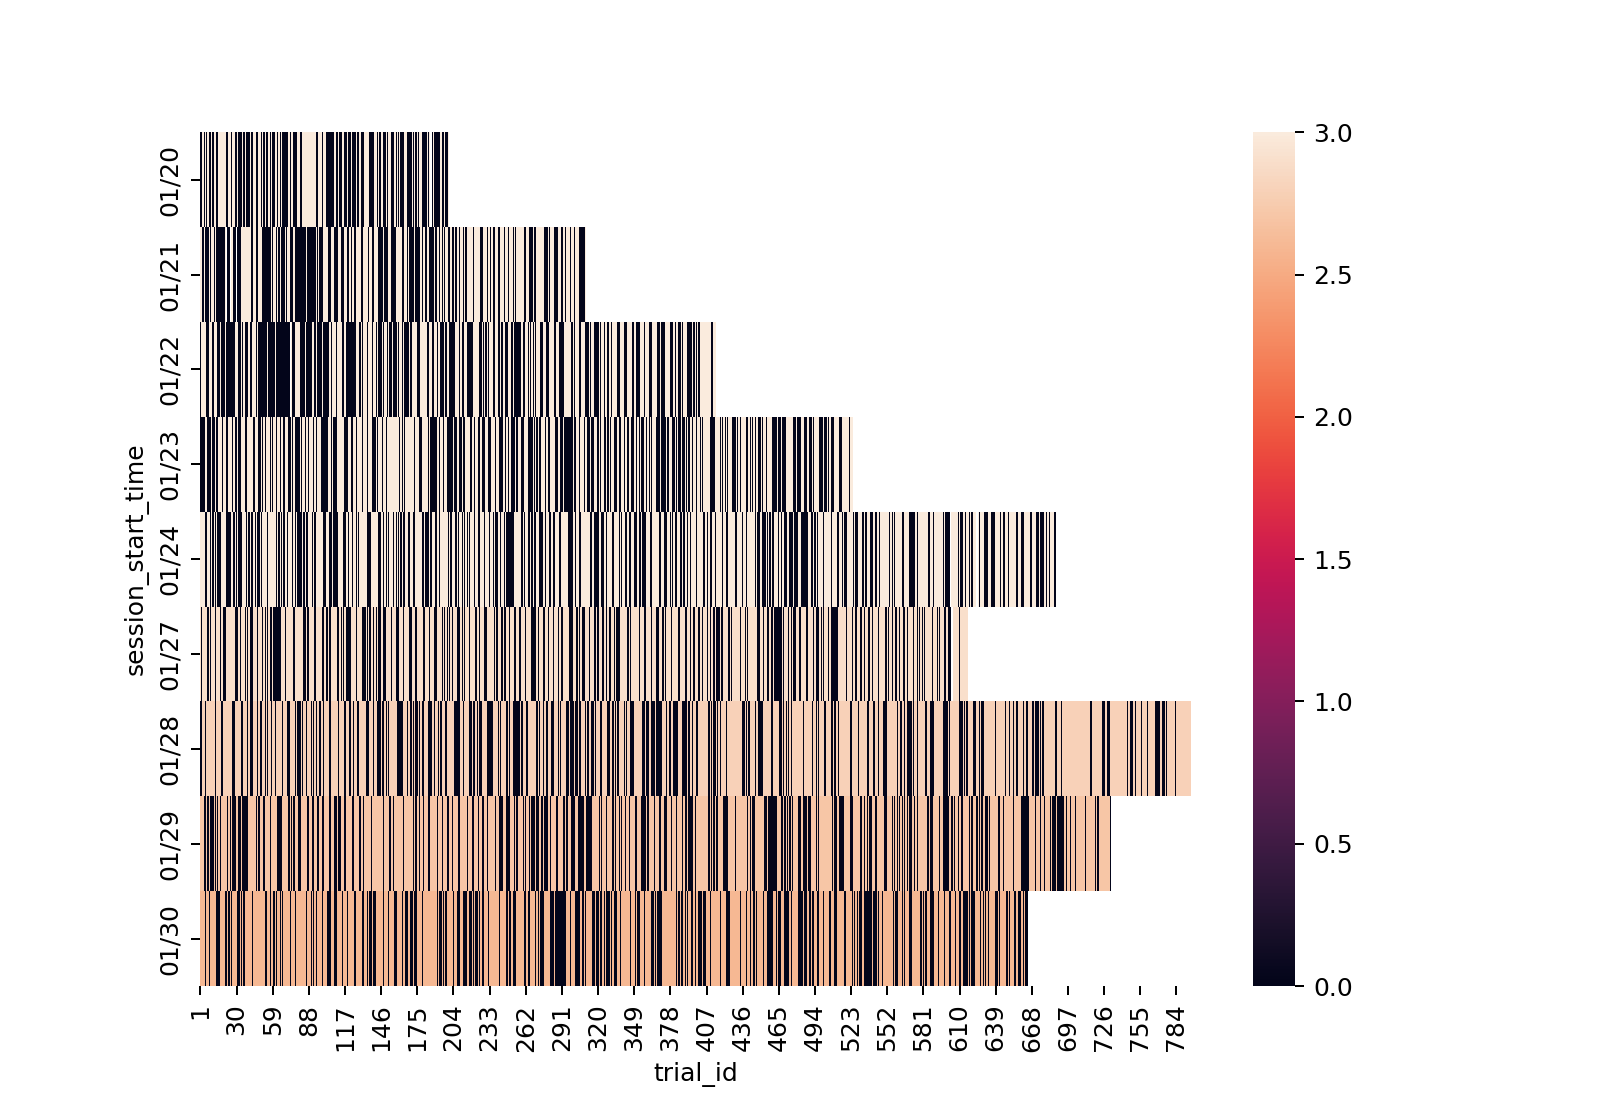

<AxesSubplot:xlabel='trial_id', ylabel='session_start_time'>

In [246]:
fig, ax = plt.subplots()

sns.heatmap(data = mat)

# Plot of reward volume for one subject per trial

/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_42096/2437220139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat['session_start_time'] = mat['session_start_time'].dt.strftime("%m/%d")


<IPython.core.display.Javascript object>


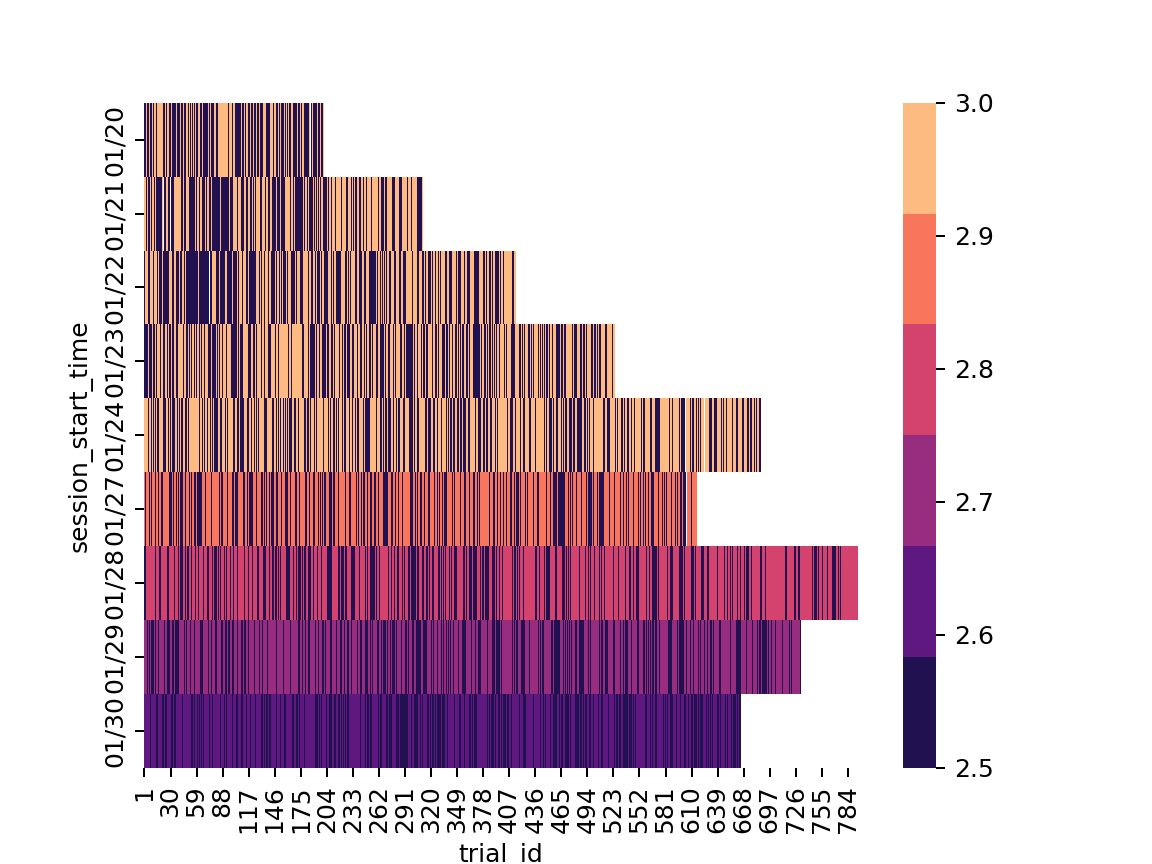

<AxesSubplot:xlabel='trial_id', ylabel='session_start_time'>

In [268]:
mat = data_per_sub[['trial_reward_volume', 'session_start_time', 'trial_id']]
mat['session_start_time'] = mat['session_start_time'].dt.strftime("%m/%d")
mat = mat.pivot(columns=['session_start_time'], values='trial_reward_volume', index='trial_id').T
fig, ax = plt.subplots()

sns.heatmap(data = mat, vmin= 2.5, cmap=sns.color_palette('magma'))